## Brief Introduction

`训练集`：(16个特征)     

| NO | 字段名称 | 数据类型 | 字段描述| --- |
| --- | --- | --- | --- | --- |
| 1 | ID | Int | 客户唯一标识| --- |
| 2 | age | Int | 客户年龄| --- |
| 3 | job | String | 客户的职业| --- |
| 4 | marital | String | 婚姻状况| --- |
| 5 | education | String | 受教育水平| --- |
| 6 | default | String | 是否有违约记录| --- |
| 7 | balance | Int | 每年账户的平均余额| --- |
| 8 | housing | String | 是否有住房贷款| --- |
| 9 | loan | String | 是否有个人贷款| --- |
| 10 | contact | String | 与客户联系的沟通方式| --- |
| 11 | day | Int | 最后一次联系的时间（几号）| --- |
| 12 | month | String | 最后一次联系的时间（月份）| --- |
| 13 | duration | Int | 最后一次联系的交流时长| --- |
| 14 | campaign | Int | 在本次活动中，与该客户交流过的次数| --- |
| 15 | pdays | Int | 距离上次活动最后一次联系该客户，过去了多久（999表示没有联系过）| --- |
| 16 | previous | Int | 在本次活动之前，与该客户交流过的次数| --- |
| 17 | poutcome | String | 上一次活动的结果| --- |
| 18 | y | Int | 预测客户是否会订购定期存款业务 | --- |

- `AUC`计分
- 提交格式：

| ID |	pred |
| --- | --- |
| 25318 | 0.123456 |
| 25319	| 0.654321 | 
| 25320	| 0.799212 | 

## Data Processing

In [350]:
import pandas as pd
import numpy as np

from copy import deepcopy
from collections import Counter

from sklearn.model_selection import train_test_split

In [351]:
train_data = pd.read_csv('../Data/train_set.csv')

train_data.tail()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
25312,25313,55,blue-collar,divorced,primary,no,8180,no,no,cellular,14,may,854,2,360,1,failure,1
25313,25314,52,services,married,secondary,no,961,no,yes,cellular,18,feb,222,1,553,4,failure,1
25314,25315,35,blue-collar,divorced,primary,no,300,yes,no,unknown,13,may,945,2,-1,0,unknown,1
25315,25316,37,entrepreneur,divorced,tertiary,no,66,no,no,cellular,18,nov,1164,2,-1,0,unknown,1
25316,25317,52,management,married,tertiary,no,40,no,no,cellular,19,nov,1265,3,-1,0,unknown,1


In [352]:
int_fea_names = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
str_fea_names = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
label_name = ['y']

In [353]:
from collections import Counter
na_un = {na:train_data[na].describe().get('unique', -1) for na in str_fea_names}
na_co = {na+'*':len(Counter(train_data[na])) for na in int_fea_names}

na_total = dict(na_un, **na_co)

na_total

{'job': 12,
 'marital': 3,
 'education': 4,
 'default': 2,
 'housing': 2,
 'loan': 2,
 'contact': 3,
 'month': 12,
 'poutcome': 4,
 'age*': 75,
 'balance*': 5736,
 'day*': 31,
 'duration*': 1388,
 'campaign*': 43,
 'pdays*': 493,
 'previous*': 36}

In [354]:
pd.DataFrame(na_total, index=[0])

,job,marital,education,default,housing,loan,contact,month,poutcome,age*,balance*,day*,duration*,campaign*,pdays*,previous*
0,12,3,4,2,2,2,3,12,4,75,5736,31,1388,43,493,36


## \*试图利用day和month补全pdays

### Choose columns which need supplement

In [368]:
df_tra_pdays = deepcopy(train_data[train_data['pdays']>0][['ID', 'day', 'month', 'pdays']])   # 4643
df_val_pdays = deepcopy(train_data[train_data['pdays']<0][['ID', 'day', 'month', 'pdays']])   # 20674

print(df_tra_pdays.shape, df_val_pdays.shape)

(4643, 4) (20674, 4)


In [369]:
df_tra_pdays.head(3)

,ID,day,month,pdays
1,2,7,apr,251
11,12,1,apr,239
20,21,21,nov,182


### Split data used for supplement 

In [370]:
X_tra_pdays, y_tra_pdays = df_tra_pdays[['day', 'month']], df_tra_pdays[['pdays']]
X_val_pdays, y_val_pdays = df_val_pdays[['day', 'month']], df_val_pdays[['pdays']]

In [371]:
X_val_pdays.head(3)

,day,month
0,9,may
2,14,jul
3,18,jul


### one-hot encoding

In [372]:
one_hot_tra_pdays = pd.concat([X_tra_pdays, pd.get_dummies(X_tra_pdays['month'], prefix='month')], axis=1)

# Drop the previous rank column
one_hot_tra_pdays = one_hot_tra_pdays.drop('month', axis=1)

# Print the first 10 rows of our data
one_hot_tra_pdays.head(3)

,day,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
1,7,1,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0
20,21,0,0,0,0,0,0,0,0,0,1,0,0


In [373]:
one_hot_val_pdays = pd.concat([X_val_pdays, pd.get_dummies(X_val_pdays['month'], prefix='month')], axis=1)

# Drop the previous rank column
one_hot_val_pdays = one_hot_val_pdays.drop('month', axis=1)

# Print the first 10 rows of our data
one_hot_val_pdays.head(3)

,day,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,9,0,0,0,0,0,0,0,0,1,0,0,0
2,14,0,0,0,0,0,1,0,0,0,0,0,0
3,18,0,0,0,0,0,1,0,0,0,0,0,0


In [374]:
X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(one_hot_tra_pdays, y_tra_pdays, test_size=0.2)

X_train_one_hot.shape, y_train_one_hot.shape, X_test_one_hot.shape, y_test_one_hot.shape

((3714, 13), (3714, 1), (929, 13), (929, 1))

### MLP

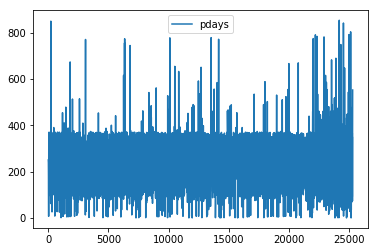

In [375]:
y_tra_pdays.plot(y='pdays')

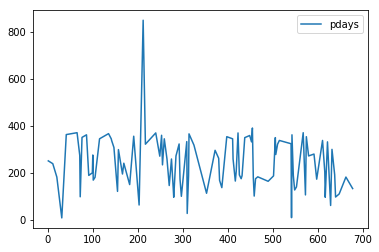

In [376]:
y_tra_pdays.iloc[:100,].plot(y='pdays')

In [377]:
from sklearn.neural_network import MLPRegressor

In [378]:
clf = MLPRegressor(solver='adam', learning_rate_init=0.1, alpha=1e-5, hidden_layer_sizes=(16,4,), random_state=1)

clf

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16, 4), learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [379]:
clf.fit(X_train_one_hot, y_train_one_hot)

D:\setup_space_all\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16, 4), learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [380]:
"""
1.0.21001577739533775
"""
clf.score(X_test_one_hot, y_test_one_hot), clf.loss_

(0.23645593494738393, 5325.878869953192)

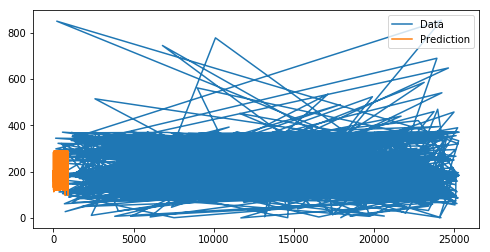

In [381]:
fig, ax = plt.subplots(figsize=(8,4))

predictions = clf.predict(X_test_one_hot)
ax.plot(y_test_one_hot, label='Data')
ax.plot(pd.DataFrame(clf.predict(X_test_one_hot)), label='Prediction')
ax.legend()

In [382]:
y_val_pdays['pdays'] = clf.predict(one_hot_val_pdays)

y_val_pdays.tail()

D:\setup_space_all\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,pdays
25308,239.532096
25310,284.146802
25314,286.710093
25315,128.924439
25316,126.361149


### combind a new DF to train

In [383]:
train_data_p = deepcopy(train_data)

# y_val_pdays
train_data_p.shape

(25317, 18)

In [384]:
l_pdays = list(train_data_p['pdays'])
for idx in list(y_val_pdays.index):
    l_pdays[idx] = y_val_pdays['pdays'][idx]
    
train_data_p['pdays'] = l_pdays

train_data_p.iloc[10:20,]

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
10,11,54,technician,married,secondary,no,1076,no,no,cellular,28,jan,338,1,167.528292,0,unknown,0
11,12,59,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239.000000,1,failure,0
12,13,48,services,married,secondary,no,473,no,yes,cellular,6,aug,198,2,173.502229,0,unknown,0
13,14,54,retired,married,primary,no,0,yes,no,cellular,11,jul,159,2,259.984213,0,unknown,0
14,15,53,management,married,tertiary,no,8627,no,no,cellular,10,feb,66,1,177.739476,0,unknown,0
15,16,30,services,single,tertiary,no,3516,yes,no,unknown,29,may,447,4,245.697452,0,unknown,0
16,17,39,technician,divorced,tertiary,no,665,yes,no,cellular,8,may,133,8,282.231444,0,unknown,0
17,18,39,technician,married,secondary,no,564,no,no,cellular,21,aug,86,4,142.515683,0,unknown,0
18,19,59,retired,married,secondary,no,1449,yes,yes,cellular,23,jul,437,2,229.224732,0,unknown,0
19,20,28,student,single,secondary,no,305,no,no,cellular,7,jul,625,1,254.022984,0,unknown,0


## ----试图利用pdays补全poutcome

```python
['unknown', 'other', 'failure', 'success']
```

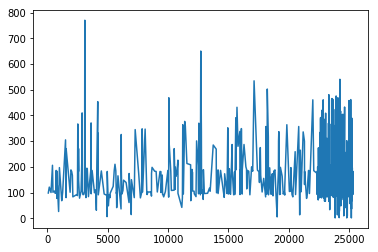

In [308]:
train_data_p[train_data_p['poutcome']=='success']['pdays'].plot()

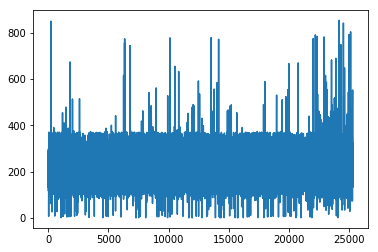

In [309]:
train_data_p[train_data_p['poutcome']!='success']['pdays'].plot()

### Choose columns whic needsupplement

In [307]:
train_data_p[train_data_p['poutcome']=='success'].head(10)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
72,73,50,management,married,tertiary,no,938,no,no,cellular,6,aug,148,2,98.0,1,success,0
155,156,40,admin.,single,secondary,no,664,no,no,cellular,19,nov,188,2,121.0,2,success,0
297,298,29,services,single,tertiary,no,1788,no,no,cellular,4,feb,303,1,100.0,1,success,0
419,420,38,student,single,unknown,no,444,no,no,cellular,8,mar,157,3,206.0,6,success,0
459,460,30,admin.,single,secondary,no,523,no,yes,cellular,12,jun,136,3,101.0,1,success,0
573,574,24,self-employed,single,tertiary,no,2376,no,no,cellular,11,aug,123,1,106.0,1,success,0
640,641,46,admin.,single,secondary,no,1693,yes,no,cellular,25,jan,137,1,97.0,1,success,0
720,721,42,technician,married,secondary,no,1066,no,no,cellular,26,may,125,1,104.0,3,success,0
727,728,41,technician,single,tertiary,no,431,no,no,cellular,26,apr,128,2,186.0,3,success,0
754,755,28,management,single,secondary,no,1633,no,no,cellular,8,sep,233,1,95.0,1,success,0


### MLP

In [317]:
t_d_unknown = deepcopy(train_data_p[train_data_p['poutcome']=='unknown'])
t_d_n_unknown = deepcopy(train_data_p[train_data_p['poutcome']!='unknown'])

t_d_unknown.shape, t_d_n_unknown.shape

((20677, 18), (4640, 18))

In [318]:
t_d_unknown['poutcome'] = [0]*t_d_unknown.shape[0]
t_d_unknown.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,294.601616,0,0,0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,243.484028,0,0,0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,246.641020,0,0,0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,232.073658,0,0,0
5,6,56,services,divorced,secondary,no,450,no,no,unknown,9,jun,47,1,173.944390,0,0,0


In [321]:
t_d_n_unknown['poutcome'] = t_d_n_unknown['poutcome'].apply(lambda x:{'other':-.2, 'failure':-1, 'success':1}[x])
t_d_n_unknown.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251.0,2,-0.2,0
11,12,59,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239.0,1,-1.0,0
20,21,31,management,single,tertiary,no,3967,yes,no,cellular,21,nov,859,1,182.0,1,-1.0,0
31,32,41,management,married,tertiary,no,1143,yes,no,cellular,5,feb,134,1,8.0,2,-0.2,0
41,42,57,retired,married,secondary,no,0,yes,no,cellular,5,may,127,1,363.0,4,-1.0,0


In [322]:
from sklearn.neural_network import MLPClassifier

In [326]:
X_train_poutcome, X_test_poutcome, y_train_poutcome, y_test_poutcome = train_test_split(
                                                                        t_d_n_unknown[['pdays', 'previous']],
                                                                        t_d_n_unknown[['poutcome']],
                                                                        test_size=.2)

X_train_poutcome.shape, X_test_poutcome.shape, y_train_poutcome.shape, y_test_poutcome.shape

((3712, 2), (928, 2), (3712, 1), (928, 1))

In [331]:
clf = MLPRegressor(solver='adam', learning_rate_init=0.1, alpha=1e-5, hidden_layer_sizes=(2,4,), random_state=1)

clf

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2, 4), learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [332]:
clf.fit(X_train_poutcome, y_train_poutcome)

D:\setup_space_all\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2, 4), learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [334]:
clf.score(X_test_poutcome, y_test_poutcome)

-0.0021788077097535385

## One-hot encoding

In [386]:
train_data_p.head(3)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,285.264784,0,unknown,0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251.000000,2,other,0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,252.294343,0,unknown,0


In [389]:
trans = deepcopy(train_data_p)
lab_data = trans['y']
one_hot_tra_pdays = trans.drop('y',axis=1)

lab_data.head(3)

0    0
1    0
2    0
Name: y, dtype: int64

In [390]:
print(one_hot_tra_pdays.shape)

# job
na = 'job'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# marital
na = 'marital'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# education
na = 'education'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# default
na = 'default'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# housing
na = 'housing'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# loan
na = 'loan'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# contact
na = 'contact'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# month
na = 'month'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

# poutcome
na = 'poutcome'
one_hot_tra_pdays = pd.concat([one_hot_tra_pdays, pd.get_dummies(train_data_p[na], prefix=na)], axis=1).drop(na, axis=1)
print(one_hot_tra_pdays.shape)

(25317, 17)
(25317, 28)
(25317, 30)
(25317, 33)
(25317, 34)
(25317, 35)
(25317, 36)
(25317, 38)
(25317, 49)
(25317, 52)


## 标准化

### ALL

In [408]:
normal_data_ALL = deepcopy(one_hot_tra_pdays[list(one_hot_tra_pdays.columns)[1:]])
normal_data_ALL.head(3)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,43,291,9,150,2,285.264784,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,42,5076,7,99,1,251.000000,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,47,104,14,77,2,252.294343,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [410]:
for n in normal_data_ALL.columns:
    maxium, minium = max(normal_data_ALL[n]), min(normal_data_ALL[n])
    a, b = .1, .9
    
    normal_data_ALL[n] = normal_data_ALL[n].apply(lambda v: (v-minium) * (b-a) / (maxium-minium) + a)
    
normal_data_ALL.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.359740,0.160356,0.313333,0.130920,0.114815,0.366602,0.100000,0.1,0.1,0.1,...,0.1,0.1,0.9,0.1,0.1,0.1,0.1,0.1,0.1,0.9
1,0.349351,0.195110,0.260000,0.120407,0.100000,0.334467,0.105818,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.9,0.1,0.1
2,0.401299,0.158998,0.446667,0.115872,0.114815,0.335681,0.100000,0.9,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.9
3,0.203896,0.151023,0.553333,0.135867,0.114815,0.326064,0.100000,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.9
4,0.349351,0.179843,0.633333,0.138547,0.159259,0.348726,0.100000,0.1,0.1,0.1,...,0.1,0.1,0.9,0.1,0.1,0.1,0.1,0.1,0.1,0.9


### only str

In [403]:
normal_data_only = deepcopy(one_hot_tra_pdays[list(one_hot_tra_pdays.columns)[1:]])
normal_data_only.head(3)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,43,291,9,150,2,285.264784,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,42,5076,7,99,1,251.000000,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,47,104,14,77,2,252.294343,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [411]:
for n in int_fea_names:
    maxium, minium = max(normal_data_only[n]), min(normal_data_only[n])
    a, b = .1, .9
    
    normal_data_only[n] = normal_data_only[n].apply(lambda v: (v-minium) * (b-a) / (maxium-minium) + a)
    
normal_data_only.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.359740,0.160356,0.313333,0.130920,0.114815,0.366602,0.100000,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.349351,0.195110,0.260000,0.120407,0.100000,0.334467,0.105818,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.401299,0.158998,0.446667,0.115872,0.114815,0.335681,0.100000,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.203896,0.151023,0.553333,0.135867,0.114815,0.326064,0.100000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.349351,0.179843,0.633333,0.138547,0.159259,0.348726,0.100000,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [407]:
for na in normal_data_ALL.columns:
    if na not in normal_data_only.columns:
        print(na)

ID


## 分割数据集

In [412]:
X_train_ALL, X_test_ALL, y_train_ALL, y_test_ALL = train_test_split(normal_data_ALL, lab_data,test_size=.3)

X_train_ALL.shape, X_test_ALL.shape, y_train_ALL.shape, y_test_ALL.shape

((17721, 51), (7596, 51), (17721,), (7596,))

In [413]:
X_train_only, X_test_only, y_train_only, y_test_only = train_test_split(normal_data_only, lab_data,test_size=.3)

X_train_only.shape, X_test_only.shape, y_train_only.shape, y_test_only.shape

((17721, 51), (7596, 51), (17721,), (7596,))

## 训练

In [415]:
%%time
"""
1.1000*100,Time:4min 3s
"""
clf = MLPClassifier(solver='adam', learning_rate_init=0.05, alpha=1e-5, hidden_layer_sizes=(25,5), random_state=1)  

clf.fit(X_train_ALL, y_train_ALL)

print('每层网络层系数矩阵维度：\n',[coef.shape for coef in clf.coefs_])

print('正确率',clf.score(X_test_ALL, y_test_ALL))

每层网络层系数矩阵维度：
 [(51, 25), (25, 5), (5, 1)]
正确率 0.9019220642443391
Wall time: 5.92 s


In [417]:
%%time
"""
1.1000*100,Time:4min 3s
"""
clf = MLPClassifier(solver='adam', learning_rate_init=0.05, alpha=1e-5, hidden_layer_sizes=(25,5), random_state=1)  

clf.fit(X_train_only, y_train_only)

print('每层网络层系数矩阵维度：\n',[coef.shape for coef in clf.coefs_])

print('正确率',clf.score(X_test_only, y_test_only))

每层网络层系数矩阵维度：
 [(51, 25), (25, 5), (5, 1)]
正确率 0.906003159557662
Wall time: 4.99 s


## 预测

In [423]:
result = clf.predict_proba(X_test_only)

len(result), X_test_only.shape

(7596, (7596, 51))

In [425]:
res_end = [l[1] for l in result]

res_end[:10]

[0.0028372571821560144,
 0.19783128686443457,
 0.021740801451244296,
 0.005315462224817821,
 0.8018390500497847,
 0.0006171837421325308,
 0.48104371847900324,
 0.001618940637246558,
 0.10157523647989487,
 0.23397607001380735]

In [418]:
from sklearn.metrics import roc_auc_score # AUC score

In [426]:
roc_auc_score(y_test_only, res_end)

0.9216838969267964